In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-01-10 12:52:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-01-10 12:52:48 (5.86 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



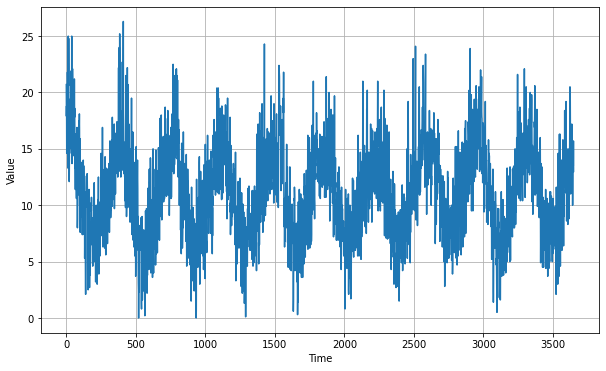

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  data=csv.reader(csvfile, delimiter=',')
  next(data)
  step=0
  for row in data:
    temps.append(float(row[1]))
    time_step.append(step)
    step=step+1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    dataset=tf.expand_dims(series, axis=-1)
    dataset=tf.data.Dataset.from_tensor_slices(dataset)
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.map(lambda x: (x[:-1], x[1:]))
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda x: x.batch(window_size))
    dataset=dataset.batch(32).prefetch(1)
    forecast=model.predict(dataset)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(16, 5, padding='causal', strides=1, input_shape=[None, 1], activation='relu'),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Dense(20, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 78ms/step - loss: 76.5459 - mae: 77.0458 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 77ms/step - loss: 74.5426 - mae: 75.0425 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 80ms/step - loss: 71.7085 - mae: 72.2085 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 80ms/step - loss: 68.5874 - mae: 69.0873 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 81ms/step - loss: 65.3687 - mae: 65.8686 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 62.0799 - mae: 62.5798 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 79ms/step - loss: 58.5838 - mae: 59.0836 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 79ms/step - loss: 54.6207 - mae: 55.1205 - l

(1e-08, 0.0001, 0.0, 60.0)

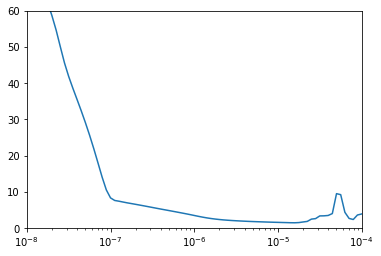

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(16, 5, padding='causal', strides=1, input_shape=[None, 1], activation='relu'),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Dense(20, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)

])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 10s 59ms/step - loss: 15.9129 - mae: 16.4054
Epoch 2/30
25/25 [==============================] - 2s 58ms/step - loss: 3.4466 - mae: 3.9163
Epoch 3/30
25/25 [==============================] - 2s 59ms/step - loss: 1.7635 - mae: 2.2148
Epoch 4/30
25/25 [==============================] - 2s 58ms/step - loss: 1.5368 - mae: 1.9843
Epoch 5/30
25/25 [==============================] - 2s 60ms/step - loss: 1.4179 - mae: 1.8604
Epoch 6/30
25/25 [==============================] - 2s 58ms/step - loss: 1.3495 - mae: 1.7896
Epoch 7/30
25/25 [==============================] - 2s 58ms/step - loss: 1.3061 - mae: 1.7441
Epoch 8/30
25/25 [==============================] - 2s 59ms/step - loss: 1.2778 - mae: 1.7140
Epoch 9/30
25/25 [==============================] - 2s 58ms/step - loss: 1.2515 - mae: 1.6864
Epoch 10/30
25/25 [==============================] - 2s 58ms/step - loss: 1.2355 - mae: 1.6697
Epoch 11/30
25/25 [==============================] - 2s 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

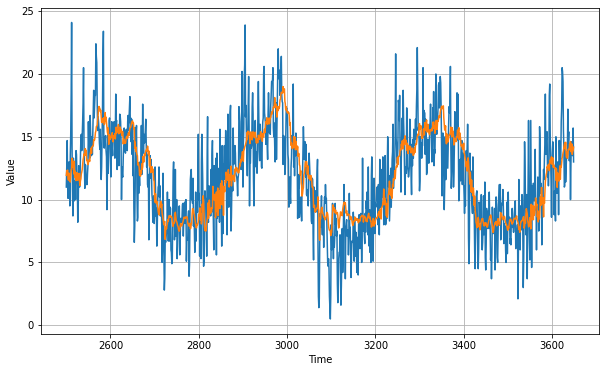

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0872962

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.930325 12.291729 12.26675  ... 13.859982 13.888812 14.175923]
